In [32]:
# !pip install pandas
# !pip install matplotlib
# !pip install openai
!pip install tqdm

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
client = OpenAI(api_key="key")
import csv
import tqdm

In [44]:
import csv

def write_to_csv(data, file_path):
    """
    Write data to a CSV file.

    Args:
    - data (list of tuples): The data to be written to the CSV file.
    - file_path (str): The file path for the CSV file.
    """
    with open(file_path, "w", newline="", encoding="utf-8") as csv_file:
        csv_writer = csv.writer(csv_file)
        # Write header
        csv_writer.writerow(["Prompt", "Output"])
        # Write data
        for prompt, output in data:
            csv_writer.writerow([prompt, output])

def is_correct(ground_truth, output):
    output = output.lower()
    if ground_truth == "accept":
        y_true = "yes"
    else:
        y_true = "no"

    if output[0:3] == y_true or output[0:2] == y_true:
        return True
    
    # print(output)
    return False
    

In [19]:
definition = """Entrapment:
- Feeling like there is no exit 
- Feeling hopeless
- Feeling like there is no way out
- Feeling afraid that things will never be normal again
- Feeling helpless to change
- Feeling trapped 
- Feeling doomed
- Feeling or thinking that things will never change
- Feeling like there is no escape
- Feeling like there are no good solutions to problems"""

In [20]:
instruction = "Is this entrapment? Yes or no."

In [28]:
zero_shot_results = []

In [34]:
# Read JSONL file into a DataFrame
entrapment_df = pd.read_json('../../../data/SCS-training-data/entrapment_train.jsonl', lines=True)
for i, row in tqdm.tqdm(entrapment_df.iterrows()):
   prompt = definition + "\n" + row["text"] + "\n" + instruction
   response = client.chat.completions.create(
      model="gpt-4-32k",
      messages=[
         {
            "role": "user",
            "content": prompt
         },
      ],
      temperature=0,
      max_tokens=256,
      top_p=0,
      frequency_penalty=0,
      presence_penalty=0
   )

   output = response.choices[0].message.content
   zero_shot_results.append((prompt, output))
   
write_to_csv(zero_shot_results, "../../../outputs/0_shot_context.csv")

121it [01:50,  1.10it/s]


In [45]:
count=0
for i, row in tqdm.tqdm(entrapment_df.iterrows()):
    answer = row["answer"]
    if is_correct(answer, zero_shot_results[i][1]):
        count+=1

print(count/len(entrapment_df))

121it [00:00, 23791.05it/s]

0.24793388429752067


In [68]:
def verbalize(label):
    if label == "accept":
        return "yes"
    else:
        return "no"
    
ten_shot_results = []
ten_shot_prompt = ""

In [69]:
# Read JSONL file into a DataFrame
for i, row in tqdm.tqdm(entrapment_df[:10].iterrows()):
   ten_shot_prompt+= "Q: " + row["text"] + "\n" + "A: " + verbalize(row["answer"]) + "\n"

10it [00:00, 11878.52it/s]


In [70]:
# Read JSONL file into a DataFrame
for i, row in tqdm.tqdm(entrapment_df[10:].iterrows()):
    prompt = definition + "\n\n" + ten_shot_prompt + "\nQ: " + row["text"] + "\nA: "
    response = client.chat.completions.create(
        model="gpt-4-32k",
        messages=[
            {
            "role": "user",
            "content": prompt
            },
        ],
        temperature=0,
        max_tokens=256,
        top_p=0,
        frequency_penalty=0,
        presence_penalty=0
    )

    output = response.choices[0].message.content
    ten_shot_results.append((prompt, output))

write_to_csv(ten_shot_results, "../../../outputs/10_shot_context.csv")

111it [00:57,  1.94it/s]


In [84]:
count=0
entrapment_test_df = entrapment_df[10:].reset_index()
for i, row in tqdm.tqdm(entrapment_test_df.iterrows()):
    answer = row["answer"]
    if is_correct(answer, ten_shot_results[i][1]):
        count+=1

print(count/len(entrapment_df[10:]))

111it [00:00, 24661.92it/s]

0.5225225225225225


In [88]:
ten_shot_cot_results = []
cot_inducer = """Before stating a label, write out reasoning using the grid above about why this may/may not be entrapment, then state the label as the final word in your output:"""

In [89]:
for i, row in tqdm.tqdm(entrapment_df[10:].iterrows()):
    prompt = definition + "\n\n" + ten_shot_prompt + "\nQ: " + row["text"] + cot_inducer + "\nA: "
    response = client.chat.completions.create(
        model="gpt-4-32k",
        messages=[
            {
            "role": "user",
            "content": prompt
            },
        ],
        temperature=0,
        max_tokens=256,
        top_p=0,
        frequency_penalty=0,
        presence_penalty=0
    )

    output = response.choices[0].message.content
    ten_shot_cot_results.append((prompt, output))

write_to_csv(ten_shot_cot_results, "../../../outputs/10_shot_cot_context.csv")

111it [06:11,  3.34s/it]


In [92]:
def is_correct_check_for_last(ground_truth, output):
    output = output.lower()
    if ground_truth == "accept":
        y_true = "yes"
    else:
        y_true = "no"

    if output[-3:] == y_true or output[-2:] == y_true:
        return True
    
    # print(output)
    return False

count=0
for i, row in tqdm.tqdm(entrapment_test_df.iterrows()):
    answer = row["answer"]
    if is_correct_check_for_last(answer, ten_shot_cot_results[i][1]):
        count+=1

print(count/len(entrapment_df[10:]))

111it [00:00, 34632.73it/s]

0.34234234234234234


In [93]:
ten_shot_cot_results[0]

[('Entrapment:\n- Feeling like there is no exit\xa0\n- Feeling hopeless\n- Feeling like there is no way out\n- Feeling afraid that things will never be normal again\n- Feeling helpless to change\n- Feeling trapped\xa0\n- Feeling doomed\n- Feeling or thinking that things will never change\n- Feeling like there is no escape\n- Feeling like there are no good solutions to problems\n\nQ: [I just want to stop being alone.] I\'m a freshman in college, and I am about to finish my second semester. My grades are not great, but they aren\'t terrible either, I\'m not not fat, but I\'m not ripped either. But for some reason, for some reason un-fucking-known to me, I can\'t make friends at all. I try really hard to be social, and make friends. I go to the parties, but always feel uncomfortable, I try to drink and smoke, but hate every second of it. And every time I try to talk to someone, I can feel them looking right through me, looking down on me, and just a look that makes me feel like I would be

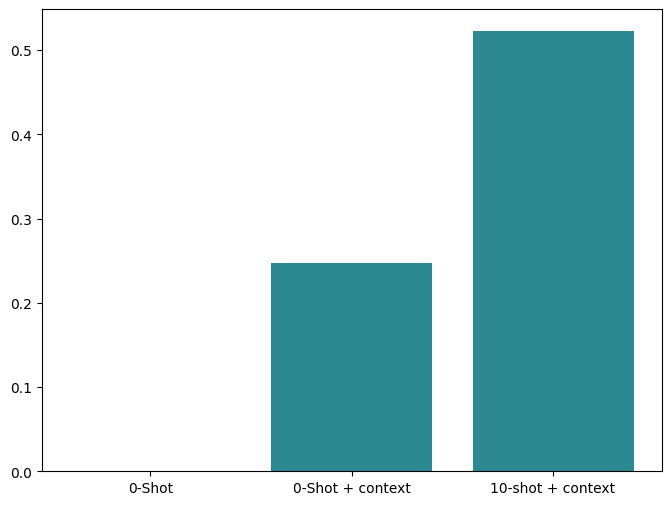

In [85]:
import matplotlib.pyplot as plt

# Define the RGBA color
rgba_color = (45 / 255, 137 / 255, 145 / 255, 1)  # Converted from rgba(45, 137, 145, 1)

# Create a vertical bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.bar(["0-Shot", "0-Shot + context", "10-shot + context"], [0, 0.24793388429752067, 0.5225225225225225], color=[rgba_color, rgba_color])

# Show plot
plt.show()
